Array-CGH is the gold standard CNV detection method. This paper: 

Celestino-Soper PB, Shaw CA, Sanders SJ, Li J, Murtha MT, Ercan-Sencicek AG, Davis L, Thomson S, Gambin T, Chinault AC, Ou Z. Use of array CGH to detect exonic copy number variants throughout the genome in autism families detects a novel deletion in TMLHE. Human molecular genetics. 2011 Aug 24;20(22):4360-70.

ran aCGH on 99 probands from SSC. We ran our deletion detection algorithm on the same individuals (from quads) using WGSd data. We want to know how the deletions we detected compare to the deletions detected by aCGH.

As a first pass, we'll look for the deletions they confirmed (so we're evaluating sensitivity).

In [26]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'individual', 'chrom', 'start_pos', 'end_pos', 'length'])

In [27]:
ddr_dels = []
with open('../other_sv_calls/ddr363_Supplementary_Data/valid_dels.txt', 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[10].lower() == 'loss':
            fam_id, chrom, start, end  = pieces[0], pieces[2][3:], int(pieces[7]), int(pieces[8])
            ddr_dels.append(Deletion(fam_id, fam_id +  '.p1', chrom, start, end, end-start+1))
print('Num DDR dels', len(ddr_dels))

Num DDR dels 167


In [28]:
# pull families that we've phased
phase_dir = '../sherlock_phased_ssc'

family_to_individuals = dict()
for j in [3, 4]:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        num_fams_of_size = 0
        for line in f:
            pieces = line.strip().split('\t')
            family_to_individuals[pieces[0].split('.')[0]] = pieces[1:(1+j)]
            num_fams_of_size += 1
        print('%d families of size %d' % (num_fams_of_size, j))

3 families of size 3
516 families of size 4


In [32]:
# find intersection between families
phased_families = set([x.split('.')[0] for x in family_to_individuals.keys()])
ddr_families = set([x.family for x in ddr_dels])
intersect_families = phased_families & ddr_families

individuals = sum([family_to_individuals[x] for x in intersect_families], [])
sample_id_to_index = dict([(x, i) for i, x in enumerate(individuals)])
m = len(individuals)
print('Families', len(intersect_families), 'Individuals', m)


Families 12 Individuals 47


In [92]:
import numpy as np

chrom = '4'
print('Ddr deletions', [x for x in ddr_dels if x.family in intersect_families and x.chrom == chrom])

# pull snp_positions for this chromosome
DATA = np.load('%s/chr.%s.deletions.npz' % (phase_dir, chrom))
snp_positions = DATA['snp_positions']

# add snp_positions from ddr deletions
snp_positions = set(snp_positions.tolist())
snp_positions = snp_positions | set(sum([[x.start_pos, x.end_pos] for x in ddr_dels \
                                         if x.family in intersect_families and x.chrom == chrom], []))
snp_positions = np.asarray(sorted(snp_positions))
pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])
n = snp_positions.shape[0]
print('n', n)

Ddr deletions [Deletion(family='11156', individual='11156.p1', chrom='4', start_pos=164438462, end_pos=164438597, length=136), Deletion(family='11378', individual='11378.p1', chrom='4', start_pos=69402972, end_pos=69533765, length=130794), Deletion(family='11412', individual='11412.p1', chrom='4', start_pos=69402972, end_pos=69529376, length=126405)]
n 41444


In [93]:
# load ddr deletions
ddr_deletions = np.zeros((m, n))
for d in ddr_dels:
    if d.family in intersect_families and d.chrom == chrom:
        start_index, end_index = pos_to_index[d.start_pos], pos_to_index[d.end_pos]
        print(start_index, end_index)
        ddr_deletions[sample_id_to_index[d.individual], start_index:(end_index+1)] = 1

33263 33264
16648 16848
16648 16847


In [94]:
# load our deletions
our_deletions = -np.ones((m, n))
our_id_to_index = dict([(x, i) for i, x in enumerate(DATA['sample_ids'])])
our_indices = [our_id_to_index[x] for x in individuals]
our_deletions[:, [pos_to_index[x] for x in DATA['snp_positions']]] = DATA['deletions'][our_indices, :]

In [95]:
# fix up missing deletions where we can
print('Percent missing', np.sum(our_deletions==-1)/(m*n))

# extend first and last calls to end
first_nonmissing = np.argmax(our_deletions != -1, axis=1)
last_nonmissing = np.argmax(np.flip(our_deletions, axis=1) != -1, axis=1)
for i, (fnm, lnm) in enumerate(zip(first_nonmissing, last_nonmissing)):
    our_deletions[i, 0:fnm] = 0
    our_deletions[i, (-1-lnm):n] = 0
print('Inferred ends, Percent missing', np.sum(our_deletions==-1)/(m*n))

# fill in intermediate missing values
miss_start_x, miss_start_y = np.where((our_deletions[:, :-1] != -1) & (our_deletions[:, 1:] == -1))
miss_end_x, miss_end_y = np.where((our_deletions[:, :-1] == -1) & (our_deletions[:, 1:] != -1))

print('start and end xs should be equal', np.array_equal(miss_start_x, miss_end_x))
for i, start, end in zip(miss_start_x, miss_start_y, miss_end_y):
    if our_deletions[i, start] == our_deletions[i, end+1]:
        our_deletions[i, (start+1):(end+1)] = our_deletions[i, start]
print('Inferred intermediate missing, Percent missing', np.sum(our_deletions==-1)/(m*n))

Percent missing 0.00463121731041
Inferred ends, Percent missing 0.00463121731041
start and end xs should be equal True
Inferred intermediate missing, Percent missing 0.004510572585


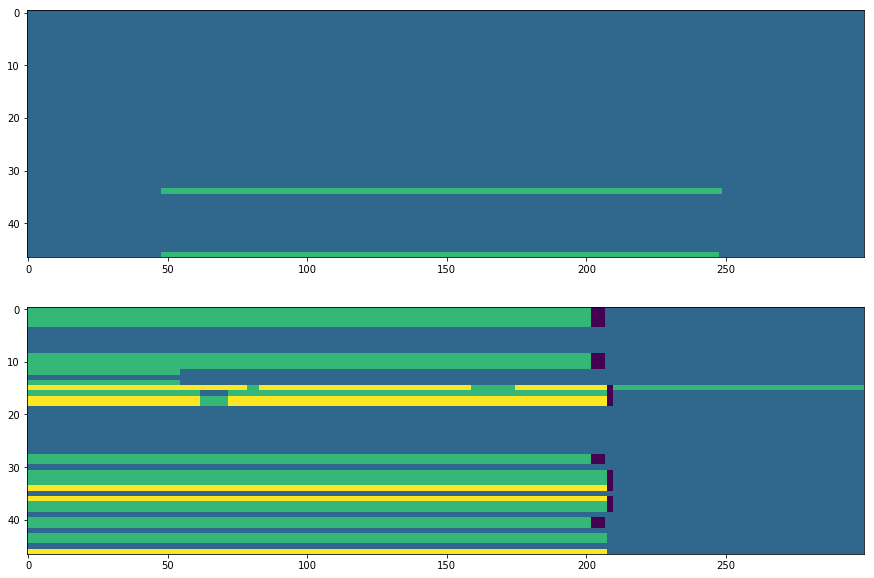

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

s, e = 16600, 16900

plt.subplot(2, 1, 1)
plt.imshow(ddr_deletions[:, s:e], aspect='auto', vmin=-1, vmax=2)

plt.subplot(2, 1, 2)
plt.imshow(our_deletions[:, s:e], aspect='auto', vmin=-1, vmax=2)

plt.show()